In [4]:
#HIGH RESOLUTION SPECTROSCOPIC DATA REDUCTION PIPELINE FOR SPATIALLY RESOLVED OBJECTS

import numpy as np
import matplotlib.pyplot as plt
import os
from astropy.io import fits
import reduction_utils as ru #import reduction functions
#import cosmics #import cosmic ray utility
from scipy.ndimage
from scipy.optimize import least_squares


%matplotlib inline 

In [4]:
#Set Paths
MainDirectory = '/Users/ryleighfitzpatrick/Desktop/Research/Titan/KeckObs/Keck2017/' #Outermost reduction directory
data_path = MainDirectory+'rawData/SPEC' #Data found here
save_path = MainDirectory+'reducedData/NIRSPEC-5-AO/Titan_HR_Offset_3/order49/Pair_1/pyRed' #Save reduction files here

#Choose Data image(s) for use in reduction
sciImgName = 'jul10s0086'
arcImgName = 'jul10s0065'
flatImgNames = ['jul10s0060','jul10s0061','jul10s0062','jul10s0063','jul10s0064']

In [6]:
%%capture 
#Ignore (pointless) astropy.io.fits warning
#ru.cosmicRayCleanup(sciImgName+'.fits', sciImgName+'_cleaned.fits')
#ru.cosmicRayCleanup(arcImgName+'.fits', arcImgName+'_cleaned.fits')
#for flatImg in flatImgNames:
#    ru.cosmicRayCleanup(flatImg+'.fits', flatImg+'_cleaned.fits')

#Read in data image(s) and header(s)
rawSpec, dataHeader = ru.readFits(sciImgName+'_cleaned.fits', head='yes')
#arcImg = ru.readFits(arcImgName+'_cleaned.fits', head='no')

#Create Median Combined Flat from all flat field images
#Read in data to list of 2D arrays (each 2D array is a flat) 
flats = [ru.readFits(f+'_cleaned.fits', head='no') for f in flatImgNames] 
flats = np.dstack(flats) #Stack Flat Images in 3D array
flatHR = np.median(flats, axis=2)#Median Combine flat images along 3rd axis (match pixels for each image)


#Look at later for reading in list of flat & bias' files
#filenames = ['file1.fits', 'file2.fits']
#imgs = [ru.readFits(fname,head='yes') for fname in filenames]

In [5]:
raw_spec = ru.readFits('/Volumes/Ryleigh/Research/Titan/KeckObs/Keck2017/rawData/SPEC/jul10s0086_cleaned.fits')

In [247]:
flatImgNames = ['jul10s0060','jul10s0061','jul10s0062','jul10s0063','jul10s0064']
flats = [ru.readFits('/Volumes/Ryleigh/Research/Titan/KeckObs/Keck2017/rawData/SPEC/'+f+'_cleaned.fits', head='no') 
         for f in flatImgNames] 
flats = np.dstack(flats) #Stack Flat Images in 3D array
flat = np.median(flats, axis=2)

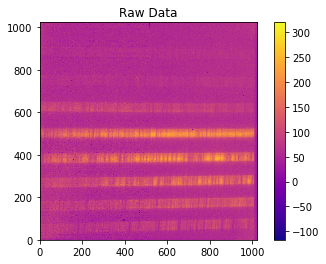

In [31]:
#plot raw data image
ru.plotFitsImage(rawSpec, title = 'Raw Data', vmin = rawSpec.min(), vmax =rawSpec.max())

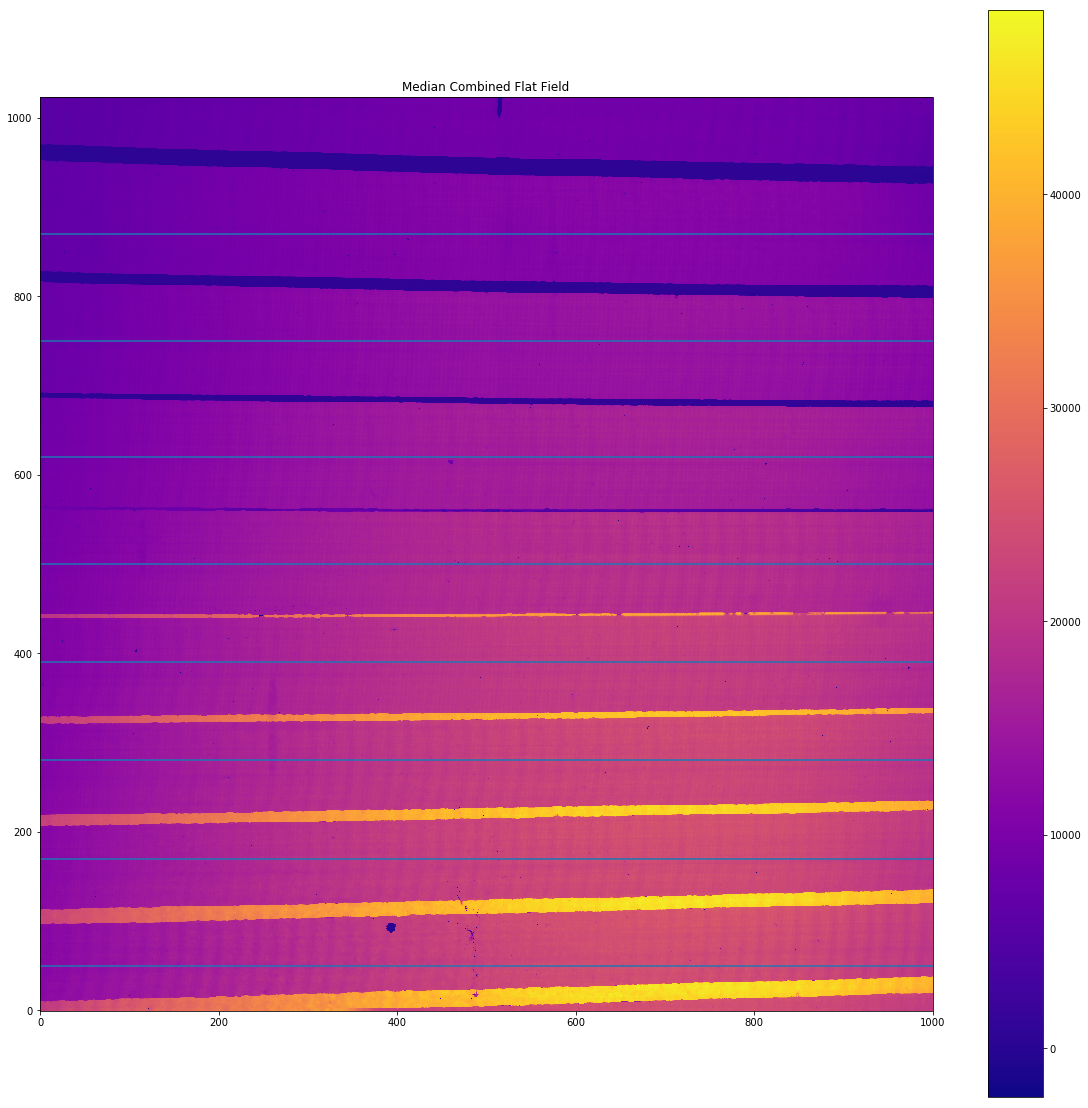

In [292]:
ru.plotFitsImage(flat, title='Median Combined Flat Field', vmin=flatHR.min(), vmax=flatHR.max(), figsize=(20,20))

order_ys = [50, 170, 280, 390, 500, 620, 750, 870]

for point in order_ys:
    plt.axhline(y=point)

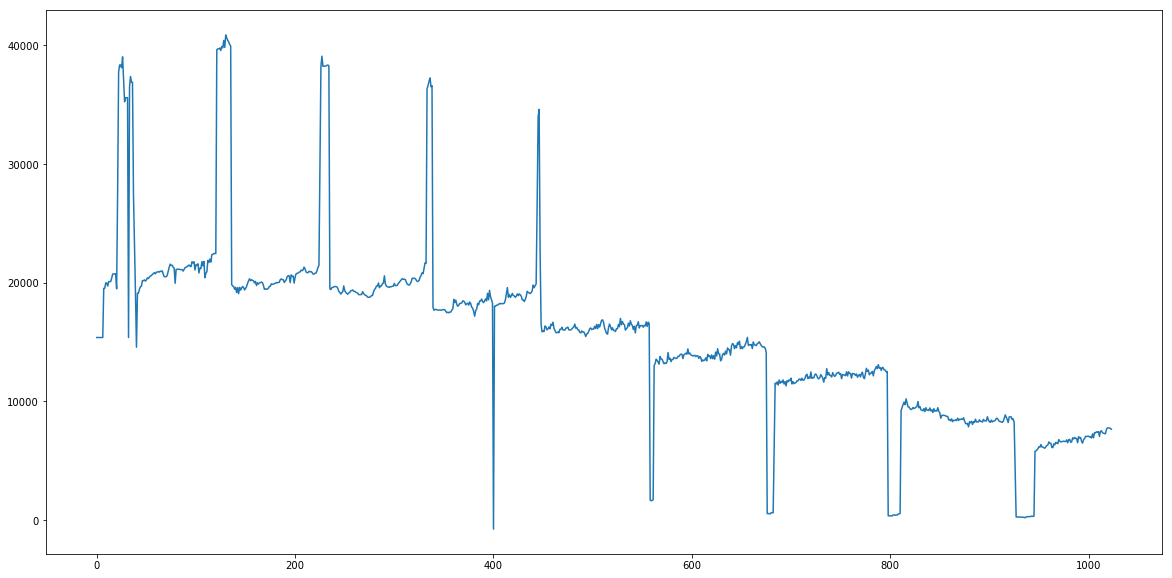

In [72]:
plt.figure(figsize=(20,10))
plt.plot(flatHR[:,500])

In [297]:
#Trim flat image
flat = flat[:,:1000]

In [298]:
def rough_boundaries_1d(slice, order_ys, sigma=2, threshold=500):
    """Find rough estimates for lower and upper boundaries of orders contained in the given vertical slice.
    
        - slice is 1d np array
        - order_ys[i] is a y-coordinate contained in the ith order
        - sigma is a smoothing parameter
        - threshold used to suppress non-boundaries. higher values suppress more.
    """
    smoothed = scipy.ndimage.filters.gaussian_filter1d(slice,sigma=sigma)
    fdiff = np.abs(smoothed[1:] -  smoothed[:-1])
    fdiff[fdiff < threshold] = 0
    candidates = argrelextrema(fdiff, np.greater)[0]

    lower = np.array([np.max(candidates[candidates < y]) for y in order_ys])
    upper = np.array([np.min(candidates[candidates > y]) for y in order_ys])
    
    return np.vstack((lower,upper))

def rough_boundaries(flat, order_ys, **kw_args):
    return np.apply_along_axis(lambda s: order_boundaries_1d(s,order_ys,**kw_args), 0, flat)

In [299]:
rough_bounds = order_boundaries(flat, order_ys, threshold=250)

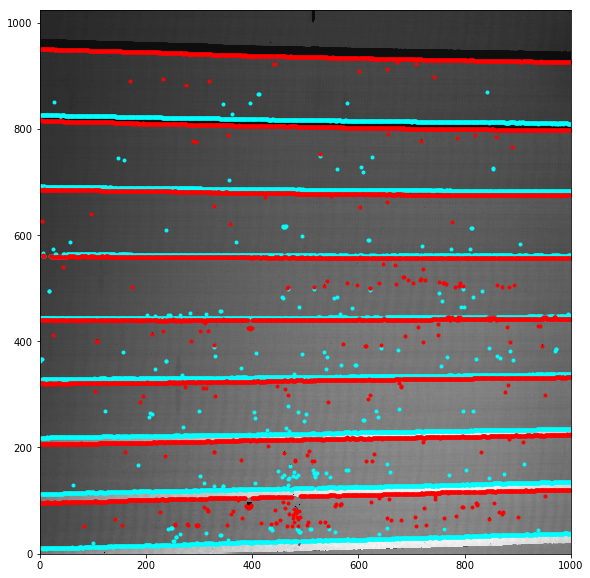

In [300]:
def plot_rough_boundaries(flat, boundaries):
    
    fig, ax = plt.subplots(figsize=(10,10))
    ax.imshow(flat, origin = 'lower', cmap='gray')

    lower = boundaries[0]
    upper = boundaries[1]
    
    def sub_plot(x,y, color='cyan'):
        ax.plot(x,y, linestyle='',marker='.',color=color)
        
    ones = np.ones(lower.shape[0])
    
    for b in [0,1]:
        if b==0:
            color='cyan'
        elif b==1:
            color='r'
        for x in range(boundaries[b].shape[1]):
            sub_plot(x*ones, boundaries[b][:,x].flatten(), color=color)
            
plot_order_boundaries(flat, rough_bounds)

In [301]:
def robust_polyfit(xs, ys, degree, initial_guess=None, loss='linear',f_scale=1.0, **kw_args):
    """Fit a polynomial, using robust regression. This is a 
    lightweight wrapper over scipy.optimize.least_squares. By default,
    it's still ordinary least squares. """
    def residual(coeffs, x, y):
        p = np.poly1d(coeffs)
        return p(x) - y
    
    if initial_guess is None:
        # use constant poly for initial guess
        initial_guess = np.zeros(degree+1) 
        initial_guess[-1] = np.mean(ys) 
    
    results = least_squares(residual, initial_guess, args=(xs,ys),loss=loss, f_scale=f_scale,**kw_args)
    
    # these are coefficients
    return results.x 

In [302]:
#NOTE: allow loss and f_scale to be kwargs so they can be changed?
def boundary_fit(rough_bounds, degree):
    """Perform a polynomial fit using robust regression for the lower or upper boundaries of
        each order. This returns the fit coefficients in an mxn numpy array where m is the 
        number of orders and n is the polynomial degree + 1.
    """
    
    xs = np.arange(rough_bounds.shape[1])
    
    def get_coeffs(ys):
        naive_coeff = np.polyfit(xs, ys, degree)
        coeff = robust_polyfit(xs, ys, degree, loss='soft_l1', f_scale=2,initial_guess=naive_coeff)
        return coeff
    
    robust_coeffs = np.apply_along_axis(get_coeffs, 1, rough_bounds)
    return np.vstack(robust_coeffs)

In [303]:
def identify_order_boundaries(flat, order_ys, order, sigma=2, threshold=250):
    
    rough_bounds = order_boundaries(flat, order_ys, sigma=sigma, threshold=threshold)
    
    lower_coeffs = boundary_fit(rough_bounds[0], order)

    upper_coeffs = boundary_fit(rough_bounds[1], order)
    
    return lower_coeffs, upper_coeffs

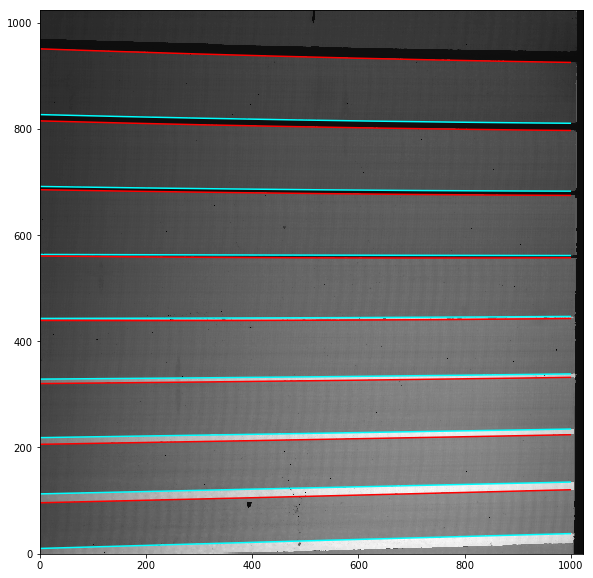

In [304]:
test_lower, test_upper = identify_order_boundaries(flat, order_ys, 2)

fig, ax = plt.subplots(figsize=(10,10))
ax.imshow(flatHR, origin = 'lower', cmap='gray')

for order_num in range(test_lower.shape[0]):
    p = np.poly1d(test_lower[order_num])
    ax.plot(xs, p(xs),color='cyan')
    
for order_num in range(test_upper.shape[0]):
    p = np.poly1d(test_upper[order_num])
    ax.plot(xs, p(xs),color='r')

# Separate Data By Order

In [ ]:
# trim(...)
#    a[5:1000] or something similar

# separate_orders(rawSpec, flatHR, method = 'vertcut')
#     returns a list of "spatially rectified" numpy arrays
#     only those orders which have sufficient data will be included

# from list of orders, either a) build dict or b) have additional list of order numbers (for later bookkeeping)

# plotOrders(...) -- maybe

TO DO: Refactor order separation
        - dead code elimination
        - format of orderStartEnd --> check how it is being used
        - break plotting part out from main logic
                -helper function to verify or view (call plot method)

In [7]:
from skimage import feature

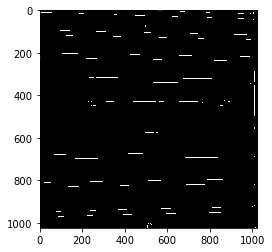

In [36]:
edges = feature.canny(flatHR, sigma=10, low_threshold= 50,high_threshold=600)
plt.imshow(edges, cmap=plt.cm.gray)
#,low_threshold= , high_threshold=

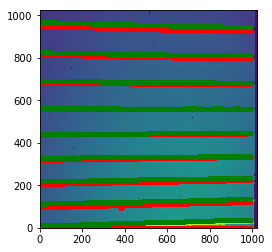

In [9]:
orderSeparation, orderStartEnd = ru.findOrderSeparationFromFlatByVertCut(flatHR, 10, 1005, plot='yes')

In [ ]:
fwd_diff = rawSpec[1:] - rawSpec[:-1]

In [14]:
orderStartEnd.shape

(995, 9, 2)

REVISIT: Decision to trim 
        - we removed the half order at the top of the images
        - Also trimmed L and R edges (1000 to 995 pixels in x direction)
TO DO:
        - make the method explicit

In [16]:
orders = [52, 51, 50, 49, 48, 47, 46, 45]

flatByOrders = ru.splitImageByOrder(flatHR, orders, orderStartEnd)
specByOrders = ru.splitImageByOrder(rawSpec, orders, orderStartEnd)

spatRecFlat = ru.performSpatialRectification(flatByOrders, orders)  
spatRecImg = ru.performSpatialRectification(specByOrders, orders)  

REVISIT: Images computed by splitImageByOrder are not rectangular. For example,
          flatByOrders[49] is a list of 995 1d arrays, with lengths varying from 104 to 111 pixels.
          
         The rectification method converts this to a rectangular image (e.g. spatRecFlat[49] is 100x995)
         
         It is reasonable to have the two tasks of i) "splitting" the image into orders of whatever shape/format and 
         ii) "rectifying" to get rectangular orders grouped together.
         
TO DO: Consider alternative approaches to splitting by order. Right now we're treating the images as a series of 
       vertical slices.
       

In [28]:
spatRecFlat[49].shape

(100, 995)

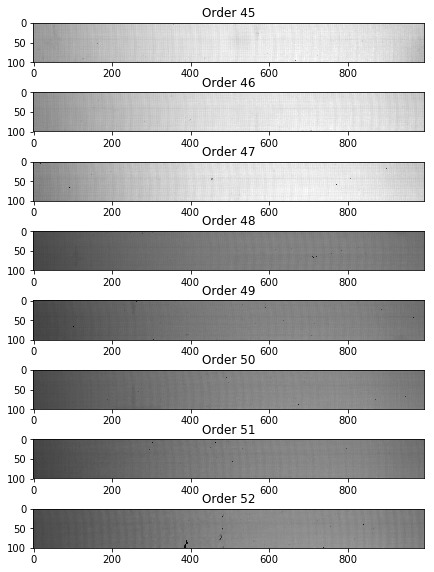

In [173]:
fig, ax = plt.subplots(8, figsize=(7,10))

for i in range(8):
    ax[i].imshow(spatRecFlat[45+i], cmap='gray', vmin = spatRecFlat[45+i].min(), vmax = spatRecFlat[45+i].max())
    ax[i].title.set_text('Order '+str(45+i))

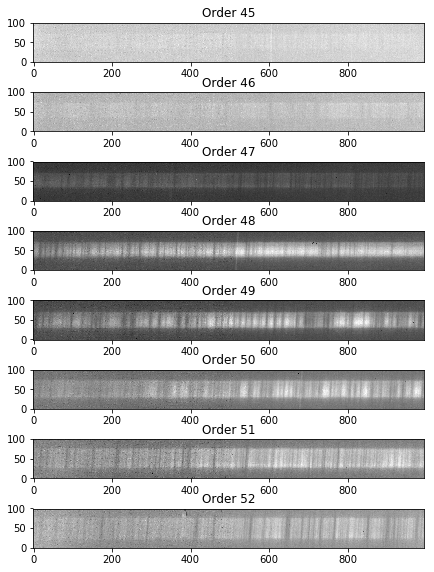

In [191]:
fig, ax = plt.subplots(8, figsize=(7,10))

for i in range(8):
    ax[i].imshow(spatRecImg[45+i], cmap='gray', origin='lower')
    ax[i].title.set_text('Order '+str(45+i))


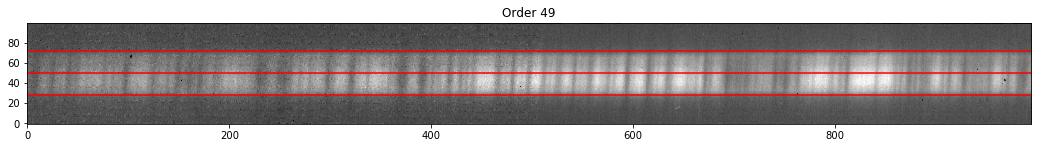

In [1966]:
fig, ax = plt.subplots(figsize=(18, 2))
ax.imshow(spatRecImg[49], cmap='gray', origin='lower')
ax.title.set_text('Order 49')

ax.axhline(y = 28, color = 'r')
ax.axhline(y = 50, color = 'r')
ax.axhline(y = 72, color = 'r')

# Spectral Rectification with Model Spectra

In [1942]:
os.chdir(MainDirectory+'KECKspectra/')

modelSpec = np.loadtxt('ModelSpec_60')

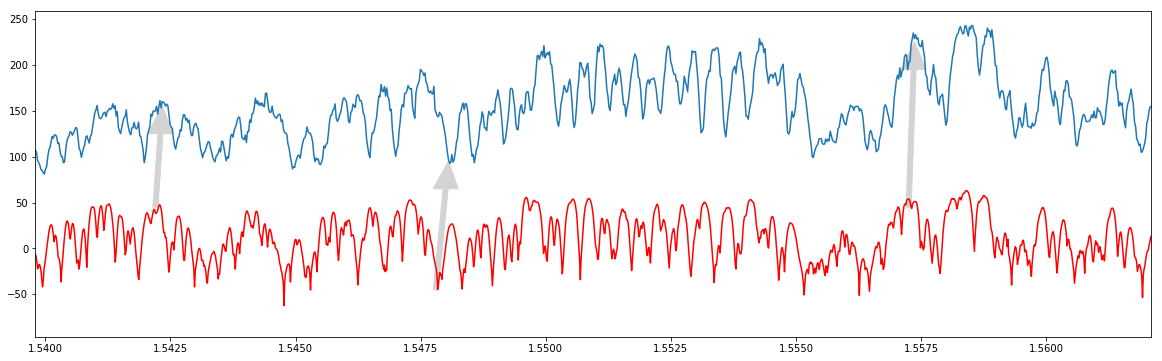

In [1939]:
#Plot data(blue) and model(red)
fig, ax = plt.subplots(figsize=(20,6))

ax.plot(np.linspace(1.5398, 1.5621, 995, endpoint=True), np.median(spatRecImg[49][40:50], 0))
ax.plot(modelSpec[:,0], (modelSpec[:,2]*1000) - 80, color='r')
ax.set_xlim(1.5398,1.5621)

ax.arrow(1.5478, -45, 0.0002, 110, width=0.0001, head_width=0.0005, head_length=30, color='lightgray')
ax.arrow(1.55725, 45, 0.0001, 150, width=0.0001, head_width=0.0005, head_length=30, color='lightgray')
ax.arrow(1.5422, 45, 0.0001, 80, width=0.0001, head_width=0.0005, head_length=30, color='lightgray')

#ax.axvline(x=1.54012)
#ax.axvline(x=1.5422)
#ax.axvline(x=1.54477)
#ax.axvline(x=1.5478)
#ax.axvline(x=1.55318)
#ax.axvline(x=1.55725)
#ax.axvline(x=1.55993)
#ax.axvline(x=1.56192)

In [1944]:
modelSpec = np.column_stack((modelSpec[:,0], modelSpec[:,2]))
print modelSpec

[[ 1.70068027  0.0266679 ]
 [ 1.70066292  0.02307822]
 [ 1.70064557  0.00920119]
 ..., 
 [ 1.45015807  0.0450716 ]
 [ 1.45014545  0.04219518]
 [ 1.45013284  0.03997879]]


In [2093]:
print spatRecImg[49]

[[ 74.          77.          62.         ...,  68.          66.          65.        ]
 [ 71.          67.          65.77777778 ...,  69.64646465  69.49494949
   74.64646465]
 [ 59.          67.          58.44444444 ...,  64.51515152  60.2020202
   67.5959596 ]
 ..., 
 [ 70.11111111  70.77777778  67.22222222 ...,  61.60606061  60.41414141
   68.29292929]
 [ 86.55555556  67.88888889  70.11111111 ...,  66.6969697   74.19191919
   69.94949495]
 [ 74.          72.          63.         ...,   0.           0.           0.        ]]


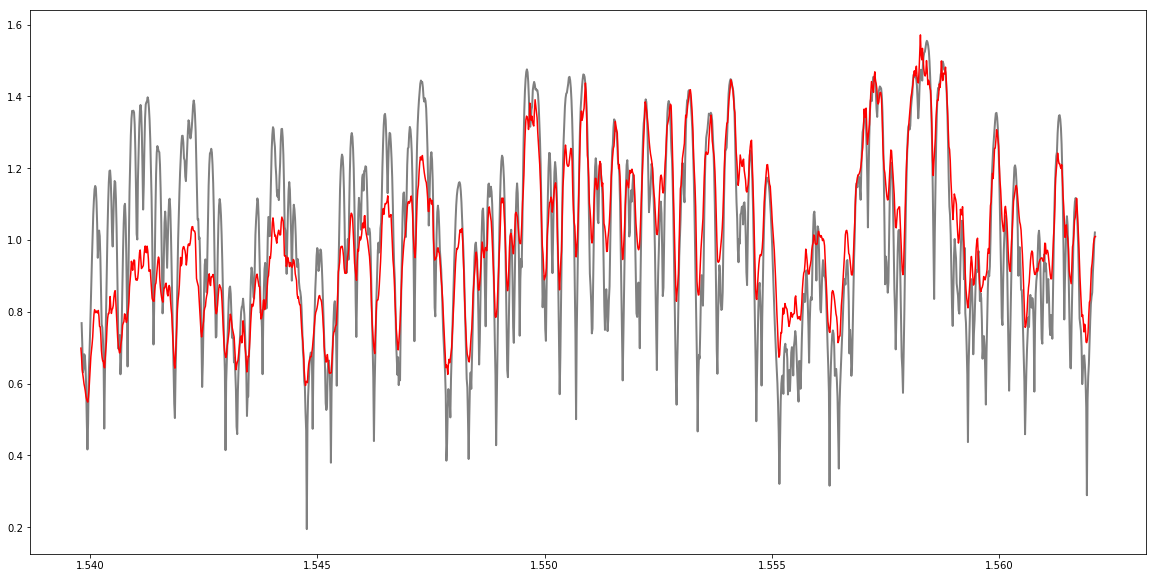

In [2094]:
#Order 49
titanSpec_N_O49, modelSpec_O49 = ru.peformSpecRecByOrderAndVertMedComb(spatRecImg, 
                                                        modelSpec, 49, [1.5398, 1.5621], [28, 50], plot = 'yes')

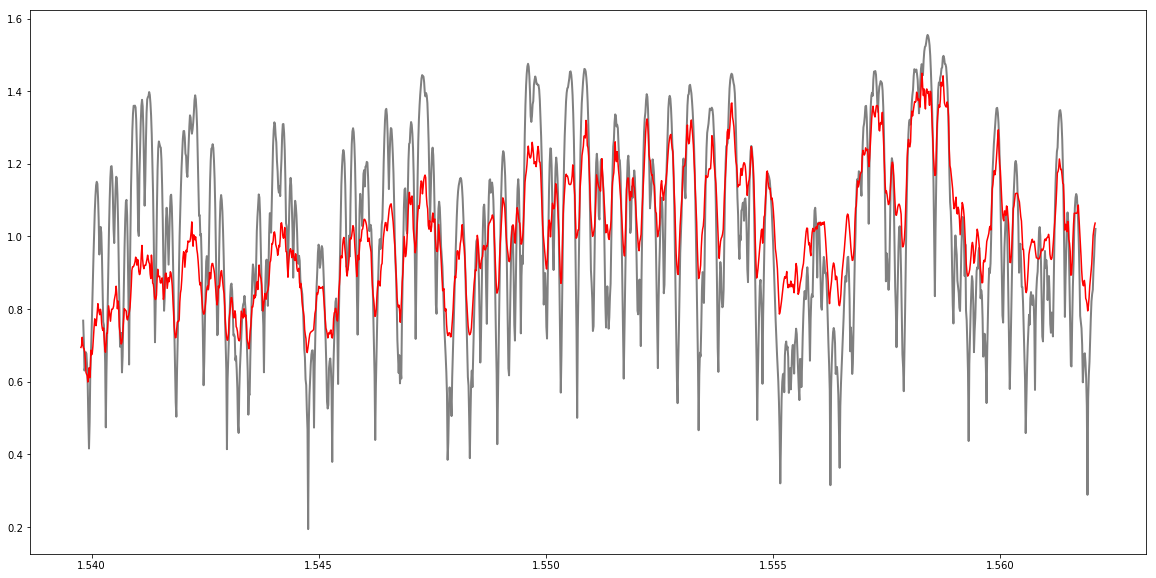

In [1970]:
#Order 49
titanSpec_S_O49, modelSpec_O49 = ru.peformSpecRecByOrderAndVertMedComb(
                                        spatRecImg, modelSpec, 49, [1.5398, 1.5621], [50, 72], plot = 'yes')

In [1982]:
import matplotlib.image as mpimg
os.chdir(MainDirectory)
titanNASA = mpimg.imread('Titan_jpg_NASA.jpg')


#We positioned the slit N-S and then
recorded 600 min observations 
starting 0.1554 arcsec to the east
of center, and stepping 0.041 (the 
slit width) west 7 times to cover
a contigous region 0.287 arc secs. 
As Titan is 0.777 arc secs in diameter, 
this is a swath covering 37% of the
disk.  

In [2044]:
#Circle radius is 420 pixels- diameter is 840 pixels
#Titan is 0.777 arcsec in diameter
#Slit width is 0.041 arcsec, length is 2.26 arcsec

imgDiameter = 840.0
imgCenter = (520., 480.)

slitWidth = ((0.041/0.777) * imgDiameter)
slitLength = ((2.26/0.777) * imgDiameter)

lowerX = []

lowerX.append(imgCenter[0] - slitWidth/4.)
lowerY = imgCenter[1] - slitLength/4.

#Start 0.1554 arcsec east of center
lowerX.append(imgCenter[0] + imgDiameter*(0.1554/0.777))

#Shift over by 0.041 arcsec west 7 times
for i in range(1,7):
    lowerX.append(lowerX[i] - imgDiameter*(0.041/0.777))

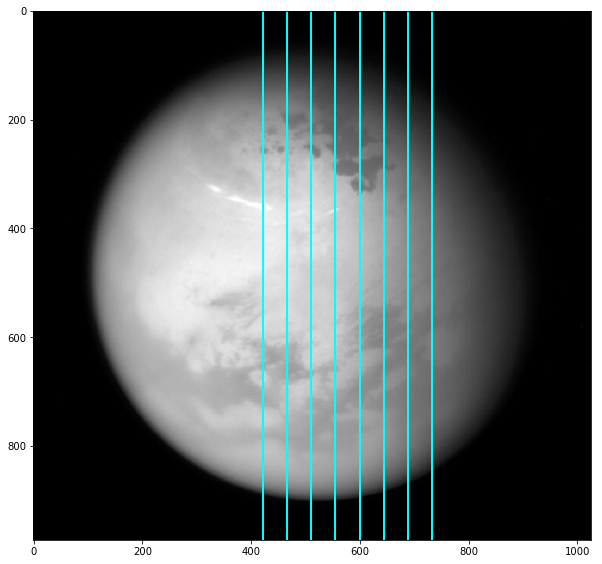

In [2058]:
import matplotlib.patches as patches
circle1 = plt.Circle((520, 480), 420, color='r', fill=False, lw = 5)
rect = patches.Rectangle((lowerX[0], lowerY), slitWidth/2., slitLength/2., lw=2,edgecolor='cyan',facecolor='none')
rect1 = patches.Rectangle((lowerX[1], lowerY), slitWidth/2., slitLength/2., lw=2,edgecolor='cyan',facecolor='none')

fig, ax = plt.subplots(figsize = (10,10))
ax.imshow(titanNASA, cmap = "gray")
#ax.add_artist(circle1)
for i in range(1,8):
    rect = patches.Rectangle((lowerX[i], lowerY), slitWidth, slitLength/2., 
                                                                 lw=2,edgecolor='cyan',facecolor='none')
    ax.add_artist(rect)

In [2080]:
index = np.where((titanSpec_N_O49[:,0] <= 1.556) & (titanSpec_N_O49[:,0] >= 1.55))
avgTitanN = np.average(titanSpec_N_O49[int(index[0][0]):int(index[0][-1]), 1])



In [2081]:
print avgTitanN

1.10455566261


(1.5686, 1.5945)

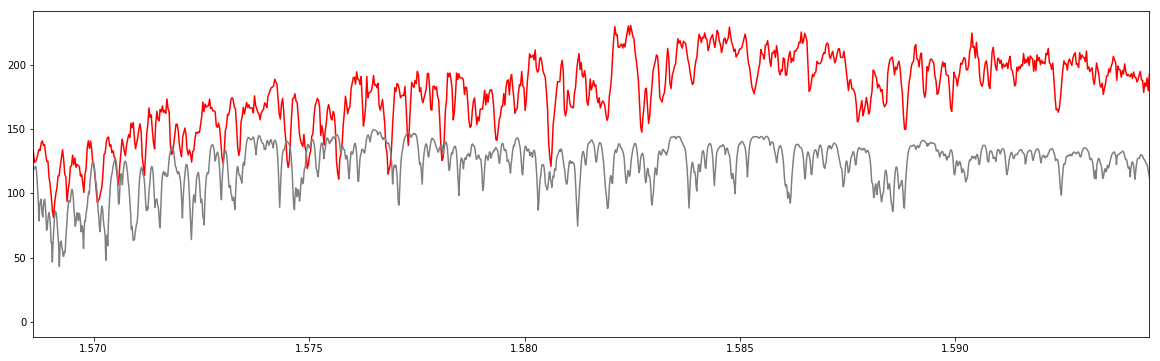

In [1925]:
#Plot data(blue) and model(red)
fig, ax = plt.subplots(figsize=(20,6))

ax.plot(np.linspace(1.5686, 1.5945, 995, endpoint=True), np.median(spatRecImg[48][40:50], 0), color = 'r')
ax.plot(modelSpec[:,0], (modelSpec[:,2]*1000) , color='gray')
ax.set_xlim(1.5686, 1.5945)

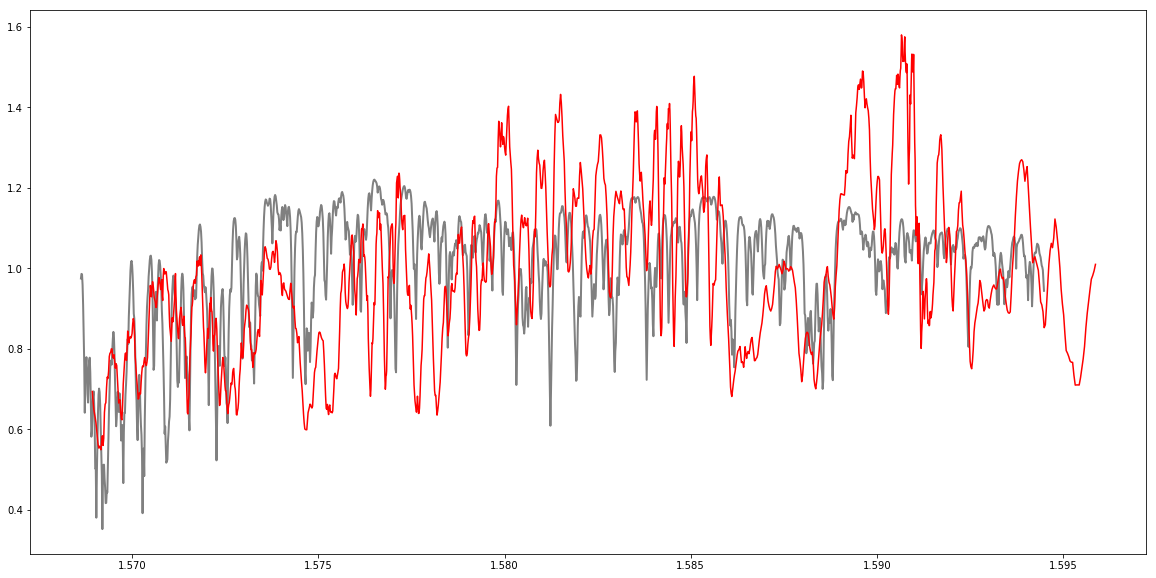

In [1924]:
ru.peformSpecRecByOrderAndVertMedComb(spatRecImg, modelSpec, 48, [1.5686, 1.59449], [40, 60], 
                                        numPoints = 15, plot = 'yes', indivPlot = 'no')
#plt.axvline(x = 1.5726)

#TO DO: Plot Earth's absorption spectrum in this region- is that why this is SO TERRIBLE?

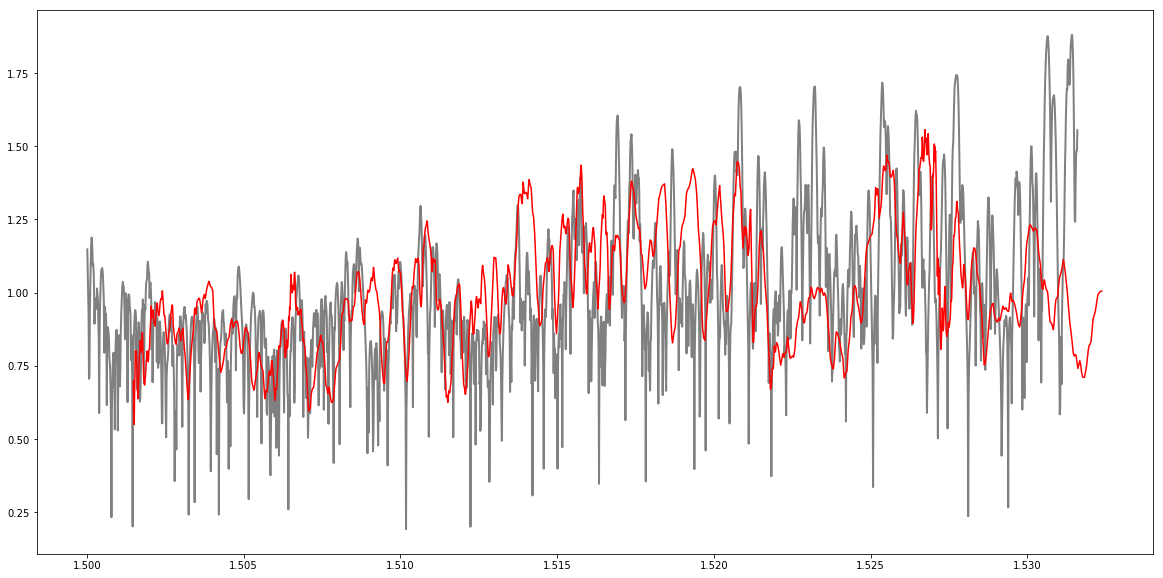

In [1866]:
#Order 50
ru.peformSpecRecByOrderAndVertMedComb(spatRecImg, modelSpec, 50, [1.50, 1.5316], [30, 50], numPoints = 15, 
                                      indivPlot = 'no', plot = 'yes')